In [50]:
from scipy.stats import invgamma
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def calc(x): #compute observations
    return np.cos(x)+np.random.randn(len(x),1)

In [52]:
#Xprime = (np.random.rand(6)*10)[:,None] #randomly spaced
Xprime = (np.linspace(0,10,6))[:,None] #evenly spaced
yprime = calc(Xprime)
X = Xprime[:-1,:]
y = yprime[:-1,:]

In [53]:
                        #Either....
#Xprime[-1:,0]=10                 #place our new sensor at the end of the domain
Xprime[-1:,0]=Xprime[0:1,0]+0.001 #place it right next to another sensor
yprime[-1:,0]=calc(Xprime[-1:,:])

In [54]:
import GPy
results = []
l = 2.0
#for l in np.logspace(-2,1,100): #compute for different lengthscales... or
for nv in np.logspace(-4,2,100): #compute for different noise variances...
    k = GPy.kern.RBF(1,lengthscale=l)
    kprime = GPy.kern.RBF(1,lengthscale=l)
    m = GPy.models.GPRegression(X,y,k,noise_var=nv)
    mprime = GPy.models.GPRegression(Xprime,yprime,kprime,noise_var=nv)
    ll = m.log_likelihood()
    llprime = mprime.log_likelihood()
    results.append([l,nv,ll,llprime])
results = np.array(results)

In [55]:
#normalise (there's a better way of doing this: https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/ )
def logsumexp(x): #modified from the above link to make it handle a matrix.
    c = np.max(x,0)
    return c + np.log(np.sum(np.exp(x - c),0))

#results[:,2:] = np.log(np.exp(results[:,2:])/np.sum(np.exp(results[:,2:]),0))
results[:,2:] = results[:,2:]-logsumexp(results[:,2:]) #normalised log probs

In [56]:
#np.sum(results[:,2:],0)

In [57]:
np.set_printoptions(precision=6,suppress=True)
results[:3,:]

array([[   2.      ,    0.0001  ,  -10.249951, -979.668681],
       [   2.      ,    0.000115,  -10.248845, -852.885687],
       [   2.      ,    0.000132,  -10.247574, -742.613   ]])

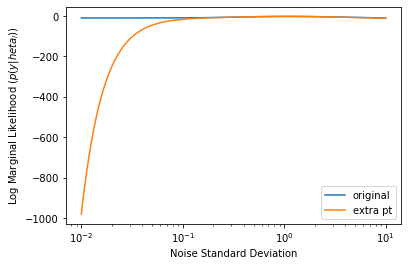

In [58]:
plt.plot(np.sqrt(results[:,1]),results[:,2],label='original')
plt.plot(np.sqrt(results[:,1]),results[:,3],label='extra pt')
#plt.xlabel('Lengthscale $\theta_l$')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Log Marginal Likelihood ($p(y|\theta_l)$)')
plt.legend()
plt.gca().set_xscale('log')
#plt.ylim([-30,0])

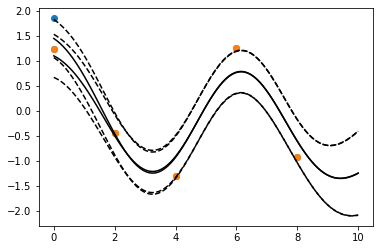

In [59]:
nv = 0.1
m = GPy.models.GPRegression(X,y,k,noise_var=nv)
mprime = GPy.models.GPRegression(Xprime,yprime,kprime,noise_var=nv)
plt.scatter(Xprime,yprime)
plt.scatter(X,y)
xtest = np.linspace(0,10,100)[:,None]
for mod in [m,mprime]:
    ypred, yvar = mod.predict(xtest)
    plt.plot(xtest,ypred,'k-')
    plt.plot(xtest,ypred-np.sqrt(yvar),'k--')
    plt.plot(xtest,ypred+np.sqrt(yvar),'k--')

In [60]:
xtest = np.linspace(0,10,100)[:,None]
ytruth = calc(xtest)
results = []
ls_samples = invgamma.rvs(1,0.1, size=200)
nv_samples = invgamma.rvs(1,0.01, size=200)
for l,nv in zip(ls_samples,nv_samples):
    print(".",end="")
    k = GPy.kern.RBF(1,lengthscale=l)
    kprime = GPy.kern.RBF(1,lengthscale=l)
    m = GPy.models.GPRegression(X,y,k,noise_var=nv)
    mprime = GPy.models.GPRegression(Xprime,yprime,kprime,noise_var=nv)
    ypred,yvar = m.predict(xtest)
    ypredprime,yvarprime = mprime.predict(xtest)
    ll = m.log_likelihood()
    llprime = mprime.log_likelihood()
    results.append([l,nv,np.sum((ypred-ytruth)**2/(2*yvar)),np.sum((ypredprime-ytruth)**2/(2*yvarprime)),ll,llprime])
results = np.array(results)

........................................................................................................................................................................................................

In [61]:
np.sum(results[:,2]*results[:,4])

-60358.49720067158

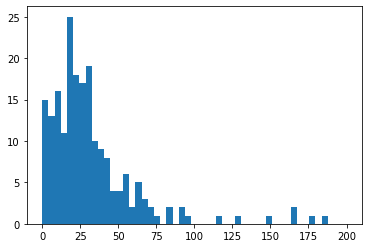

In [62]:
plt.hist(results[:,2],np.linspace(0,200,50));

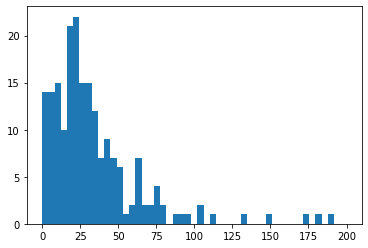

In [63]:
plt.hist(results[:,3],np.linspace(0,200,50));